# Загрузим данные по ирисам

Задача: Построить модель, которая по размерам лепестка и чашелистика классифицирует ирисы

In [1]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')
iris = datasets.load_iris(as_frame = True)
X = iris['data']
y = iris['target']

In [2]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [4]:
X_merge = pd.concat([X,y],axis = 1)

# Исследуем наш набор данных

## Взглянем на пустые значения

In [5]:
X.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

In [6]:
y.isna().sum()

0

Пустых значений нет

## Размеры данных

In [7]:
X.shape

(150, 4)

In [8]:
y.shape

(150,)

## Посмотрим на основные описательные статистики

In [9]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Взглянем на графики

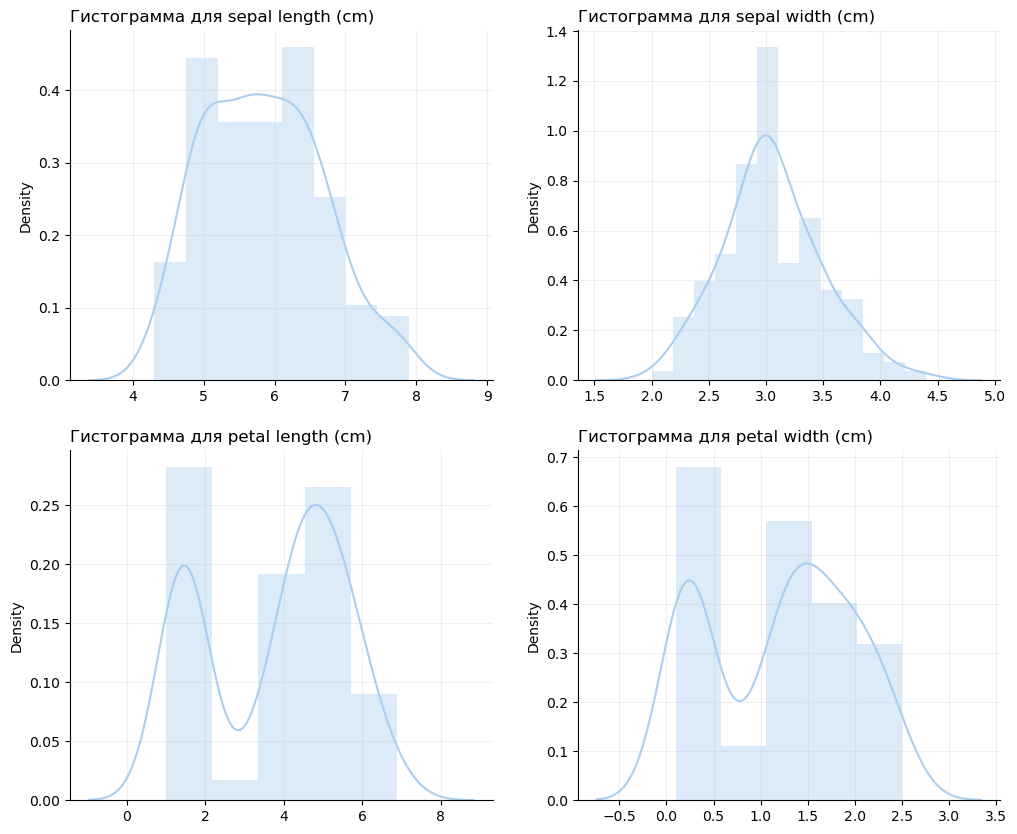

In [10]:
fig,ax = plt.subplots(nrows = 2,ncols = 2,figsize = (12,10))
t = 0
for i in range(2):
    for j in range(2):
        sns.distplot(X,x = X.iloc[:,t],ax = ax[i][j],color = '#ABCDEF')
        ax[i][j].set_title(f'Гистограмма для {X.iloc[:,t].name}',loc = 'left')
        t+= 1
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].grid(alpha = 0.19)

Ширина и длина чашелистика имеюют почти нормальное распределение, а вот для лепестков есть особенности. Они не являются унимодальным.

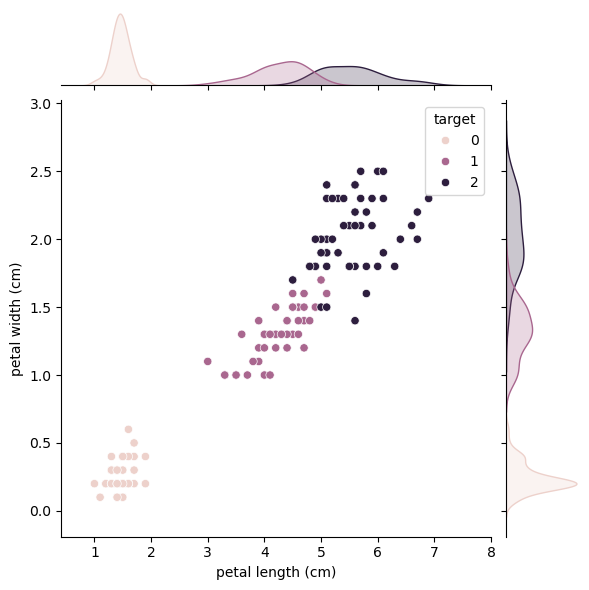

In [11]:
sns.jointplot(X_merge, x = 'petal length (cm)', y = 'petal width (cm)',hue = 'target')
plt.show()

Как можно заметить ирисы 0 класса можно разделить только по 1 из параметров лепестка, а вот 1 и 2, независимо от параметров, полностью невозможно.

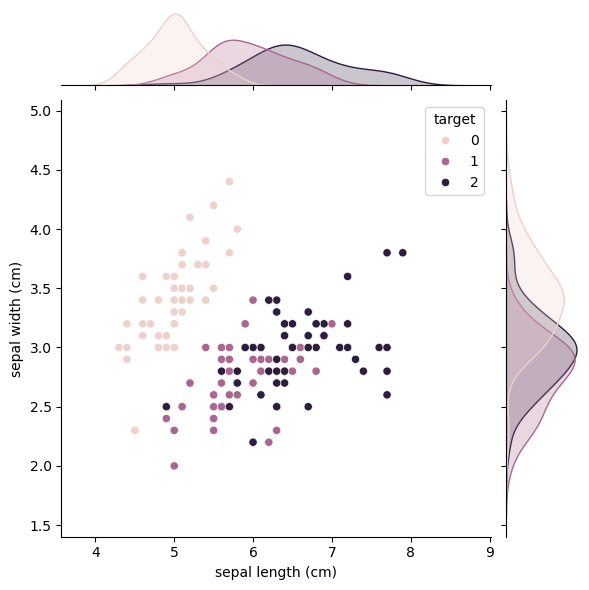

In [12]:
sns.jointplot(X_merge, x = 'sepal length (cm)', y = 'sepal width (cm)',hue = 'target')
plt.show()

Тут мы тоже можем разделить 0 класс от других, но только уже по всем параметрам чашелистика.

Взглянем на матрицу корреляций 

<Axes: >

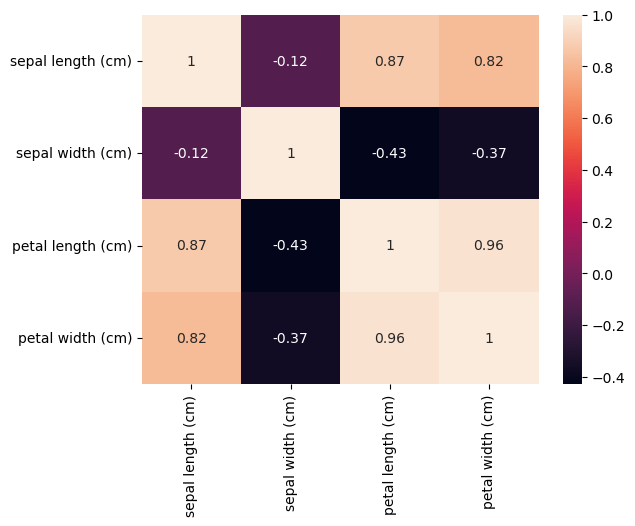

In [13]:
sns.heatmap(X.corr(),annot = True)

Petal width и Petal length слишком сильно коррелируют, причем по 1 из них можно хорошо разделить классы. Удалю petal length так как она сильнее коррелирует с sepal.

In [14]:
X.drop('petal length (cm)',axis =1,inplace = True)

# Стандартизируем наши признаки

In [15]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
df = pd.DataFrame(scal.fit_transform(X),columns=X.columns)

# Импортируем модели

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report

In [17]:
X_train,X_test,y_train,y_test = train_test_split(df,y,stratify=y, test_size=50)

In [18]:
def get_info(X_test,y_test,model):
    print(f"roc_auc = {roc_auc_score(y_test,model.predict_proba(X_test),multi_class = 'ovr')}")
    print(f"accuracy_score = {accuracy_score(y_test,model.predict(X_test))}")
    print(classification_report(y_test,model.predict(X_test)))

In [19]:
models = [
    ('log_ovr',LogisticRegression(multi_class = 'ovr')),
    ('log_mult',LogisticRegression(multi_class = 'multinomial')),
    ('tree',DecisionTreeClassifier(max_depth=3)),
    ('Bayes',GaussianNB())]

In [20]:
for name,model in models:
    model.fit(X_train,y_train)
    print(f'Модель:{name}')
    get_info(X_train,y_train,model)
    print('#############################################################')

Модель:log_ovr
roc_auc = 0.9740779170103138
accuracy_score = 0.92
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.88      0.88      0.88        33
           2       0.89      0.91      0.90        34

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

#############################################################
Модель:log_mult
roc_auc = 0.9926614698344286
accuracy_score = 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.91      0.94      0.93        33
           2       0.94      0.91      0.93        34

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

###########################################

In [21]:
svm = SVC()
svm.fit(X_train,y_train)
print(f"accuracy_score = {accuracy_score(y_train,svm.predict(X_train))}")
print(classification_report(y_train,svm.predict(X_train)))

accuracy_score = 0.96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.91      0.97      0.94        33
           2       0.97      0.91      0.94        34

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



# Возьмем лучшую модель - log_mult

In [25]:
log = models[1][1]

In [26]:
accuracy_score(log.predict(X_train),y_train)

0.95

In [27]:
print(f'точность модели на тесте: {accuracy_score(y_test,log.predict(X_test))}')
print(f"roc auc модели на тесте: {roc_auc_score(y_test,model.predict_proba(X_test),multi_class = 'ovr')}")

точность модели на тесте: 0.98
roc auc модели на тесте: 0.9927584670231728


Как видим модель хорошо способна классифицировать ирисы